In [1]:
from keras.models import load_model

model = load_model('cats_and_dogs_small_2.h5')
model.summary()

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 34, 34, 128)       73856     
_______________________________________

In [2]:
img_path = './datasets/cats_and_dogs_small/test/cats/cat.1700.jpg'

from keras.preprocessing import image
import numpy as np

img = image.load_img(img_path, target_size=(150, 150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.

print(img_tensor.shape)

(1, 150, 150, 3)


In [3]:
import matplotlib.pyplot as plt

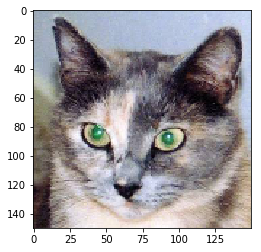

In [4]:
plt.imshow(img_tensor[0])
plt.show()

In [5]:
from keras import models

layer_outputs = [layer.output for layer in model.layers[:8]]
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)

In [8]:
activations = activation_model.predict(img_tensor)

In [9]:
first_layer_activation = activations[0]
print(first_layer_activation.shape)

(1, 148, 148, 32)


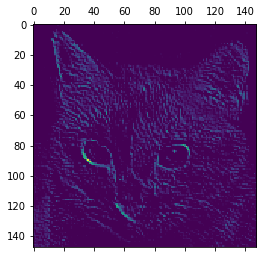

In [10]:
plt.matshow(first_layer_activation[0, :, :, 19], cmap='viridis')
plt.show()

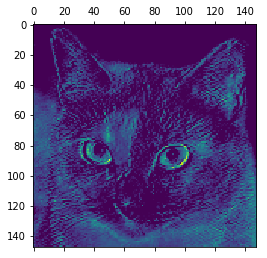

In [12]:
plt.matshow(first_layer_activation[0, :, :, 15], cmap='viridis')
plt.show()

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in true_divide


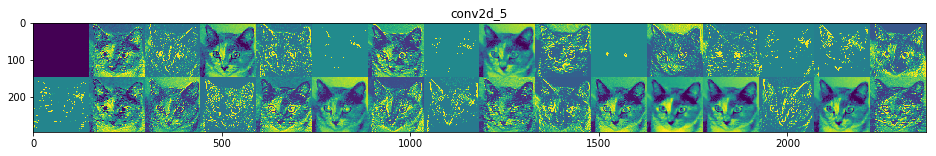

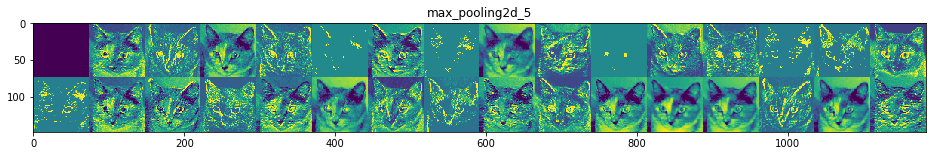

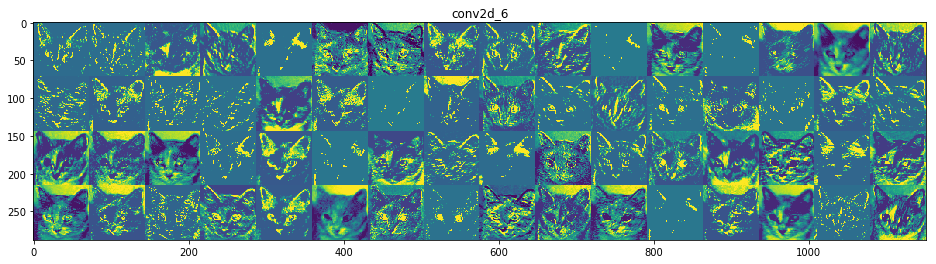

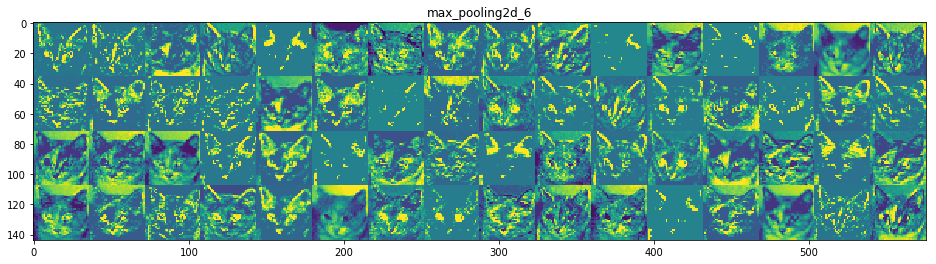

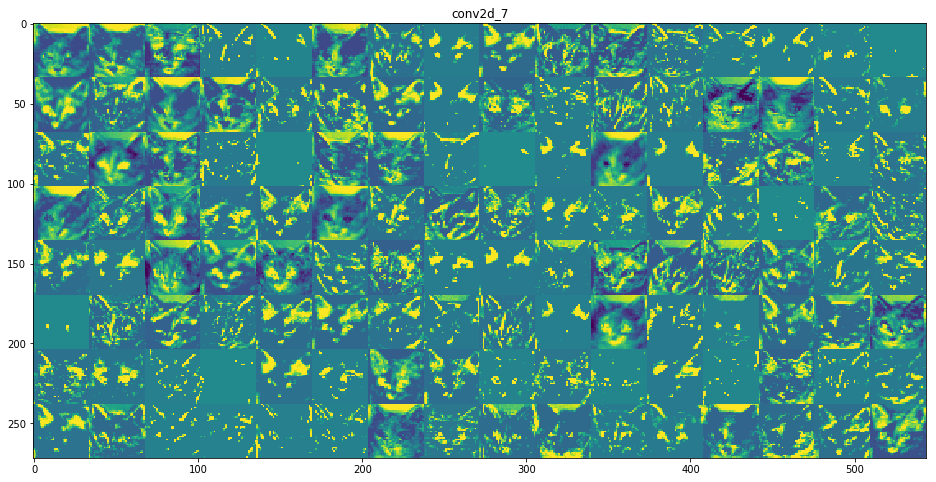

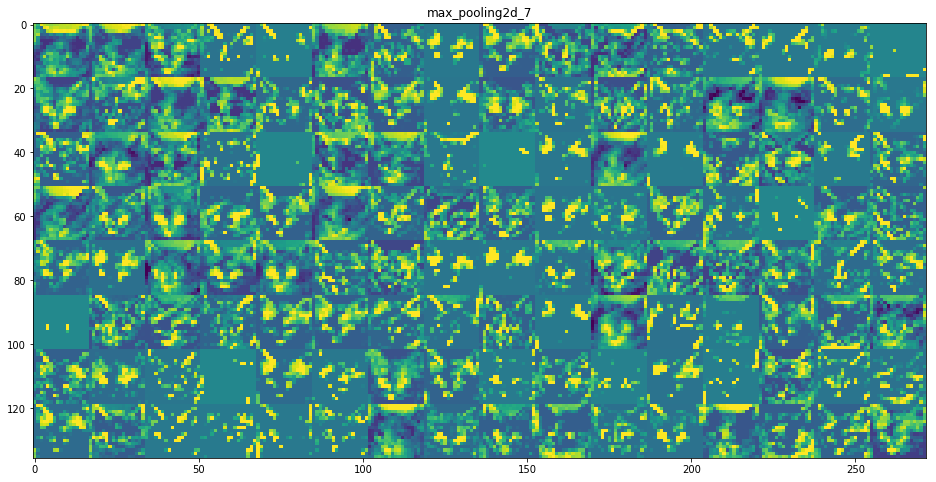

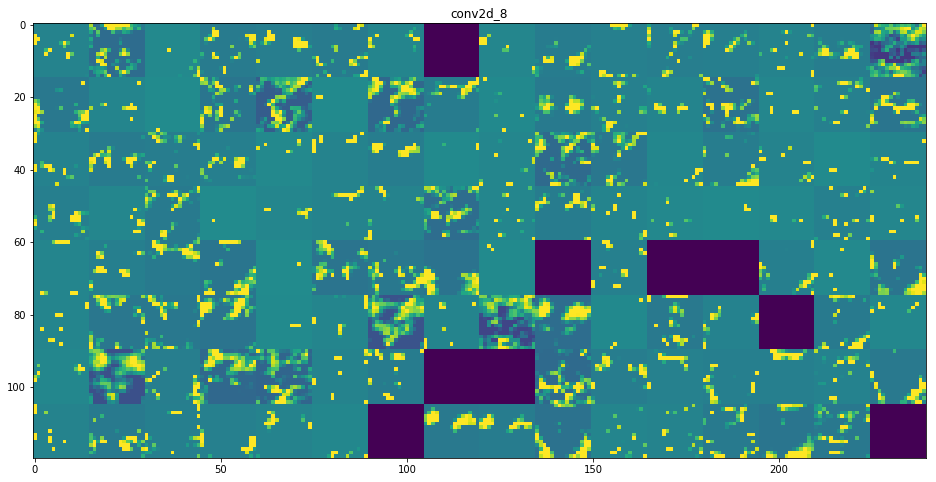

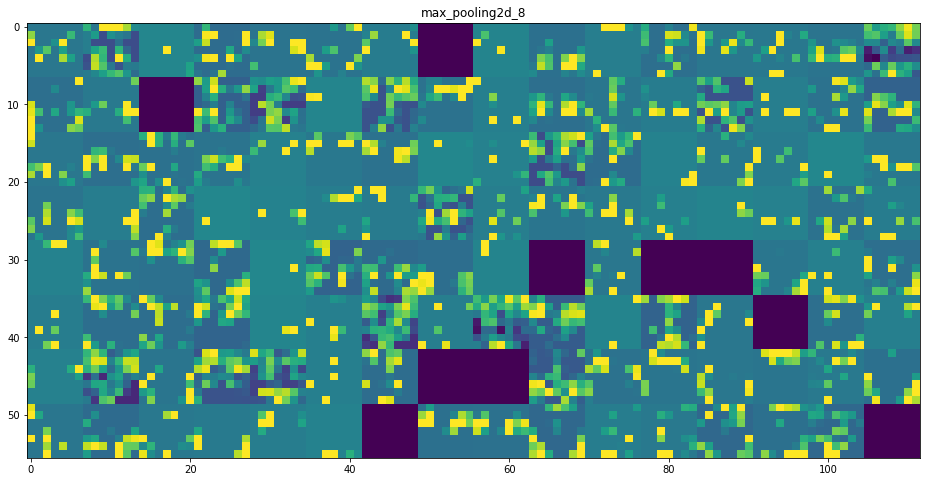

In [13]:
# 층의 이름을 그래프 제목으로 사용합니다
layer_names = []
for layer in model.layers[:8]:
    layer_names.append(layer.name)

images_per_row = 16

# 특성 맵을 그립니다
for layer_name, layer_activation in zip(layer_names, activations):
    # 특성 맵에 있는 특성의 수
    n_features = layer_activation.shape[-1]

    # 특성 맵의 크기는 (1, size, size, n_features)입니다
    size = layer_activation.shape[1]

    # 활성화 채널을 위한 그리드 크기를 구합니다
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # 각 활성화를 하나의 큰 그리드에 채웁니다
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            # 그래프로 나타내기 좋게 특성을 처리합니다
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # 그리드를 출력합니다
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

plt.show()

In [15]:
from keras.applications import VGG16
from keras import backend as K

model = VGG16(weights='imagenet',
              include_top=False)

layer_name = 'block3_conv1'
filter_index = 0

layer_output = model.get_layer(layer_name).output
loss = K.mean(layer_output[:, :, :, filter_index])

In [16]:
grads = K.gradients(loss, model.input)[0]

In [17]:
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

In [18]:
iterate = K.function([model.input], [loss, grads])

import numpy as np
loss_value, grads_value = iterate([np.zeros((1, 150, 150, 3))])

In [19]:
input_img_data = np.random.random((1, 150, 150, 3)) * 20 + 128.

step = 1.
for i in range(40):
    loss_value, grads_value = iterate([input_img_data])
    input_img_data += grads_value * step

In [20]:
def deprocess_image(x):
    # 텐서의 평균이 0, 표준 편차가 0.1이 되도록 정규화합니다
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # [0, 1]로 클리핑합니다
    x += 0.5
    x = np.clip(x, 0, 1)

    # RGB 배열로 변환합니다
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [21]:
def generate_pattern(layer_name, filter_index, size=150):
    # 주어진 층과 필터의 활성화를 최대화하기 위한 손실 함수를 정의합니다
    layer_output = model.get_layer(layer_name).output
    loss = K.mean(layer_output[:, :, :, filter_index])

    # 손실에 대한 입력 이미지의 그래디언트를 계산합니다
    grads = K.gradients(loss, model.input)[0]

    # 그래디언트 정규화
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)

    # 입력 이미지에 대한 손실과 그래디언트를 반환합니다
    iterate = K.function([model.input], [loss, grads])
    
    # 잡음이 섞인 회색 이미지로 시작합니다
    input_img_data = np.random.random((1, size, size, 3)) * 20 + 128.

    # 경사 상승법을 40 단계 실행합니다
    step = 1.
    for i in range(40):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
        
    img = input_img_data[0]
    return deprocess_image(img)

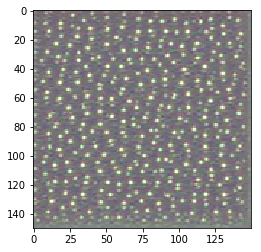

In [22]:
plt.imshow(generate_pattern('block3_conv1', 0))
plt.show()

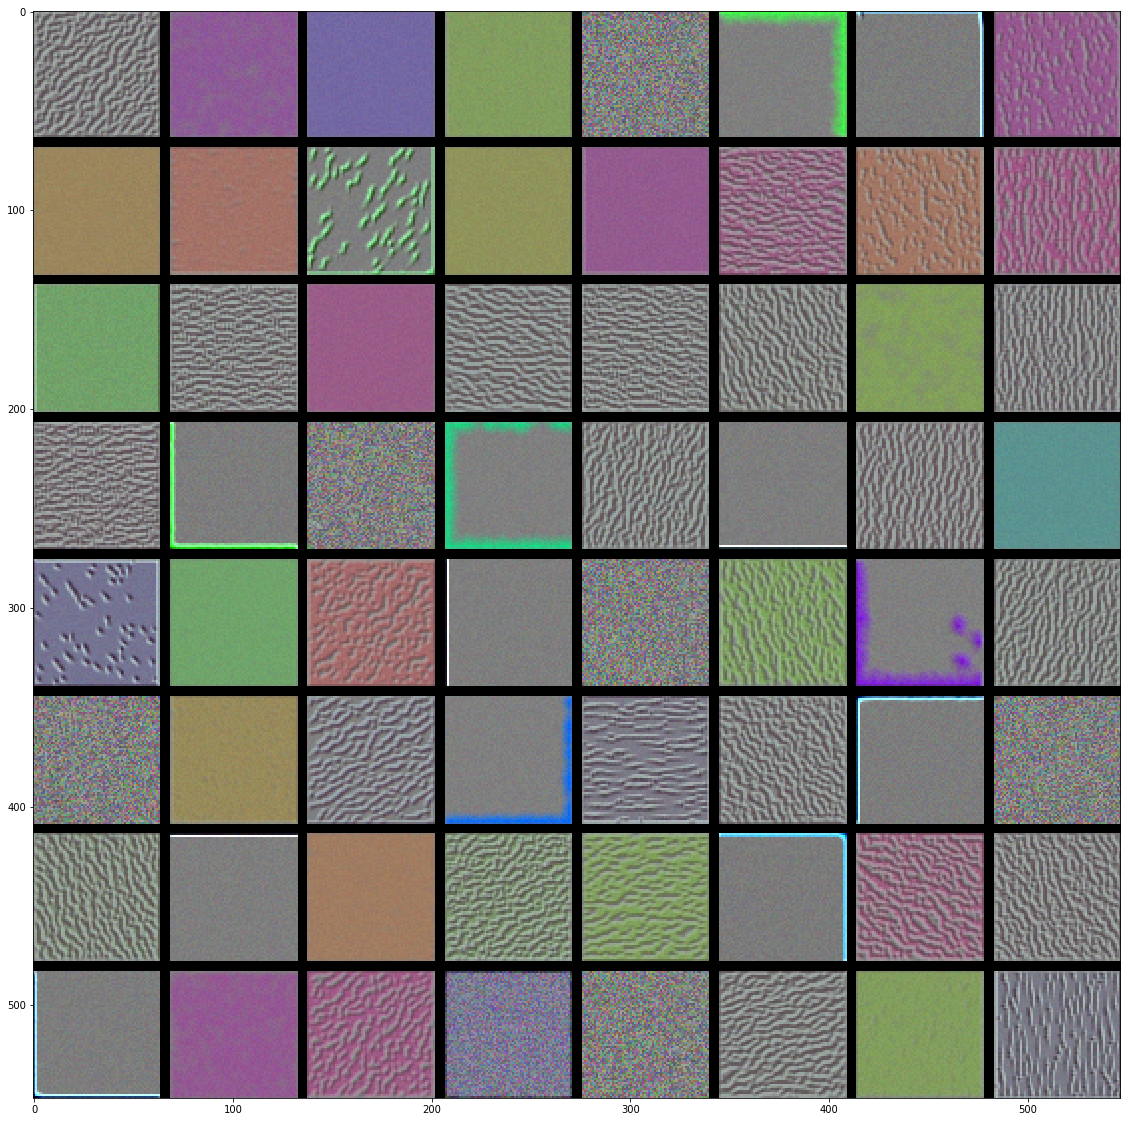

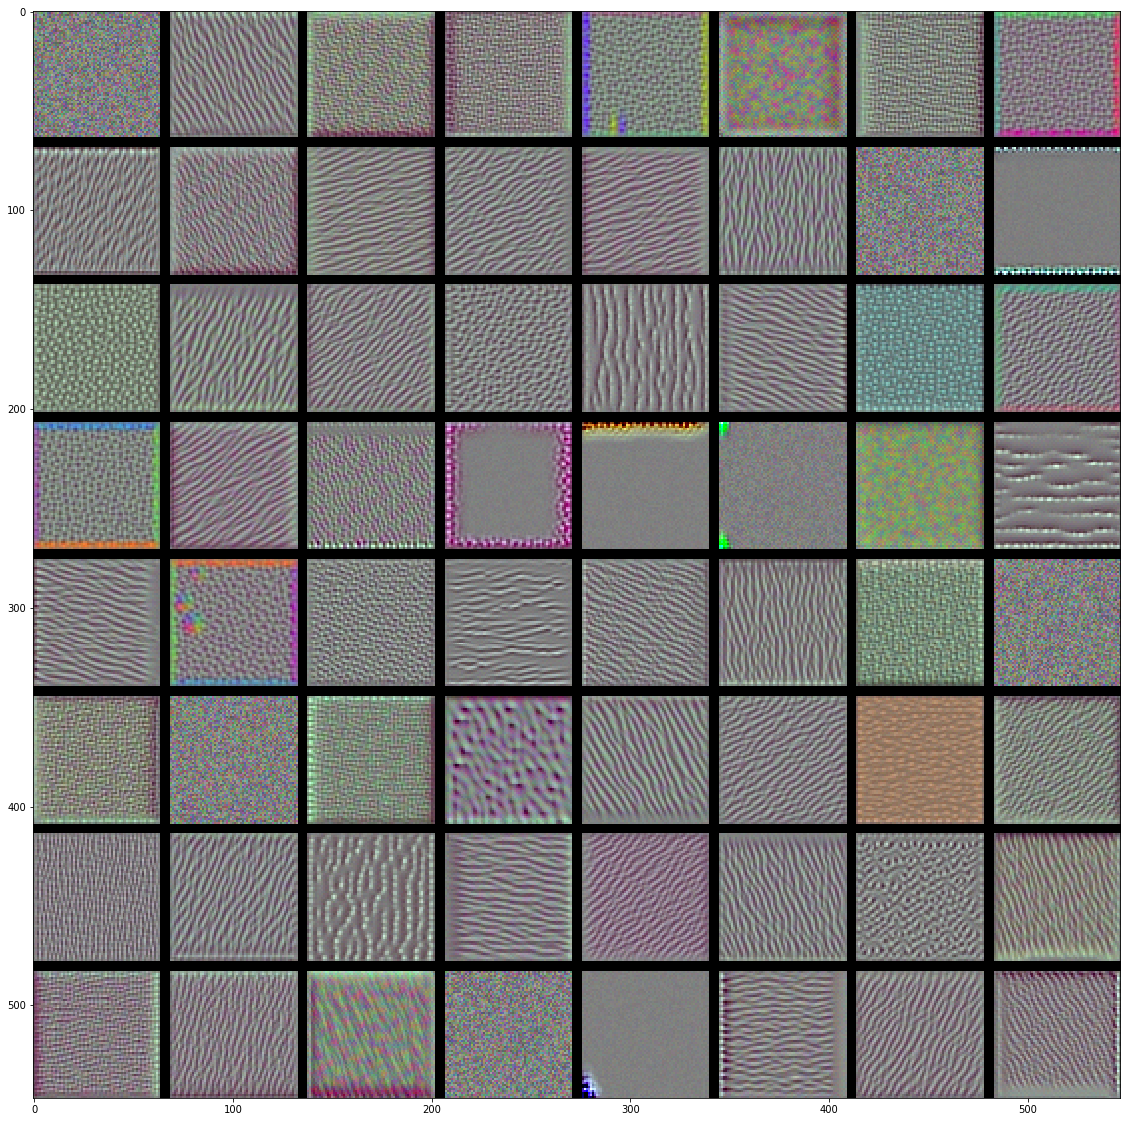

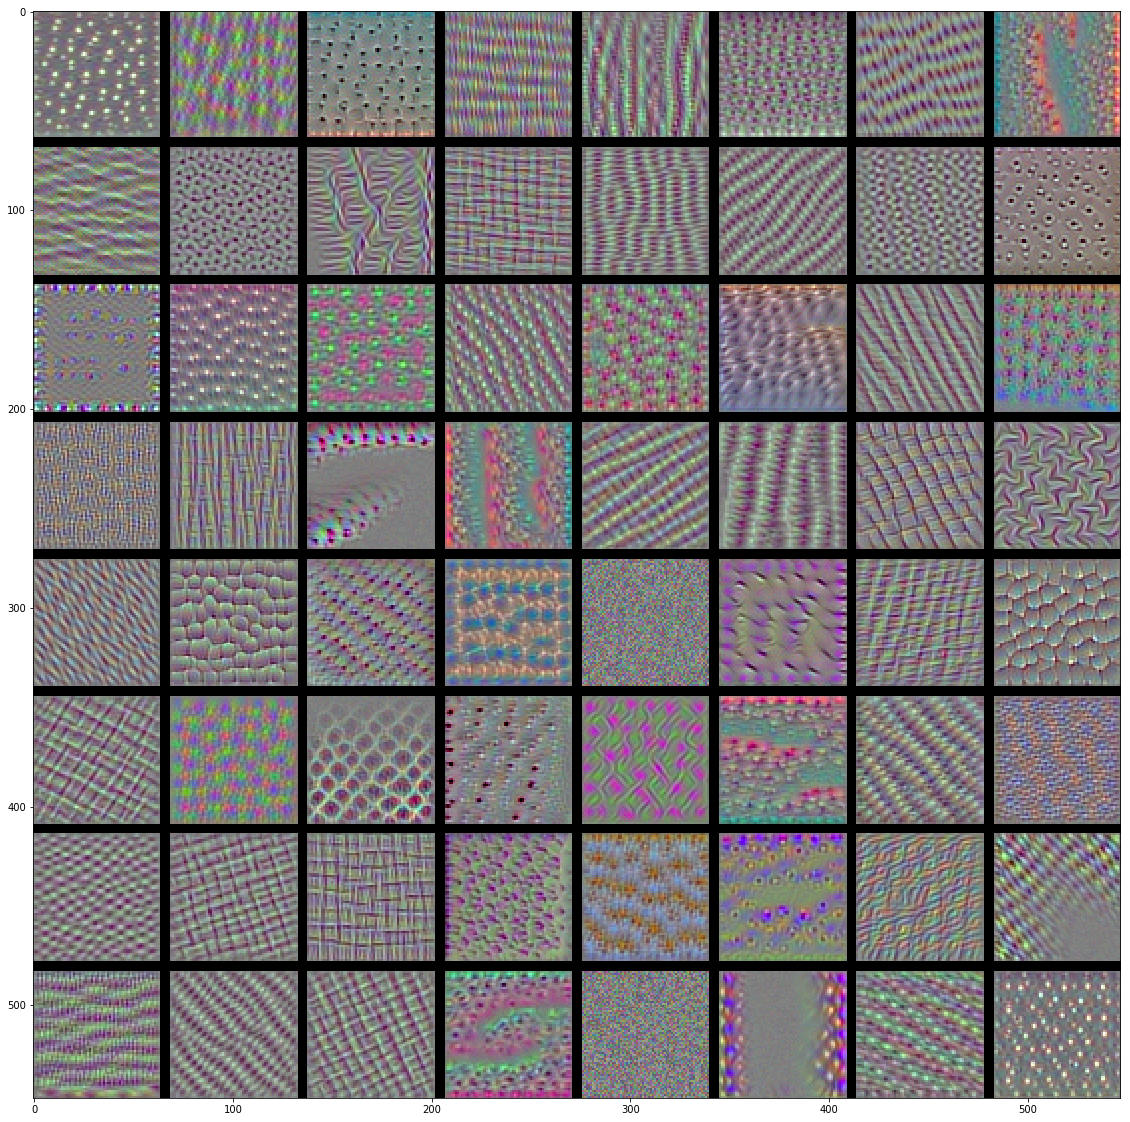

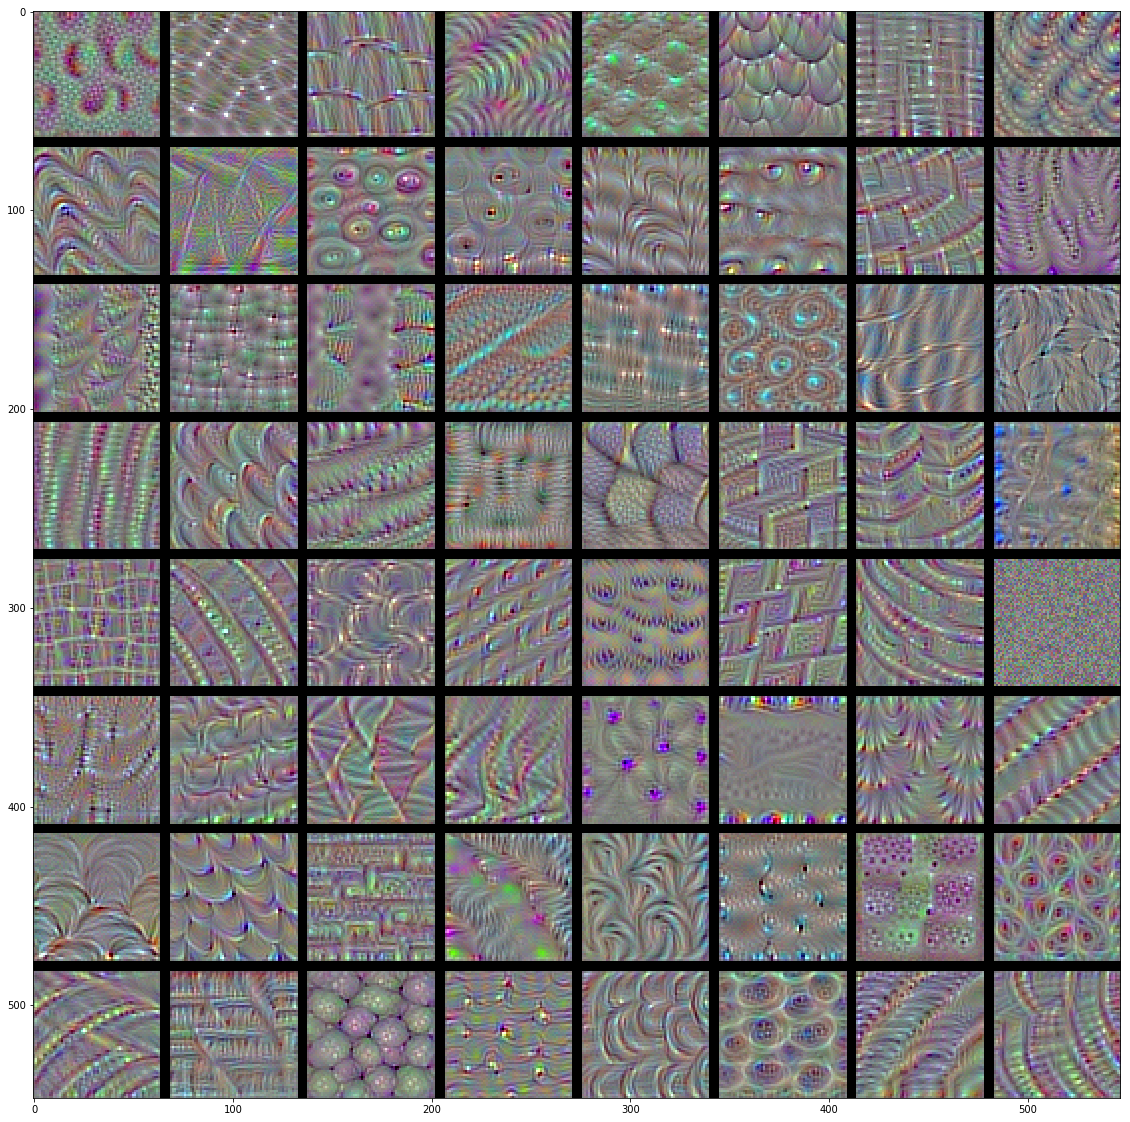

In [23]:
for layer_name in ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1']:
    size = 64
    margin = 5

    # 결과를 담을 빈 (검은) 이미지
    results = np.zeros((8 * size + 7 * margin, 8 * size + 7 * margin, 3), dtype='uint8')

    for i in range(8):  # results 그리드의 행을 반복합니다
        for j in range(8):  # results 그리드의 열을 반복합니다
            # layer_name에 있는 i + (j * 8)번째 필터에 대한 패턴 생성합니다
            filter_img = generate_pattern(layer_name, i + (j * 8), size=size)

            # results 그리드의 (i, j) 번째 위치에 저장합니다
            horizontal_start = i * size + i * margin
            horizontal_end = horizontal_start + size
            vertical_start = j * size + j * margin
            vertical_end = vertical_start + size
            results[horizontal_start: horizontal_end, vertical_start: vertical_end, :] = filter_img

    # results 그리드를 그립니다
    plt.figure(figsize=(20, 20))
    plt.imshow(results)
    plt.show()

In [24]:
from keras.applications.vgg16 import VGG16

K.clear_session()

model = VGG16(weights='imagenet')

553467904/553467096 [==============================] - 263s 0us/step


In [28]:
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input, decode_predictions
import numpy as np

# 이미지 경로
img_path = './datasets/creative_commons_elephant.jpg'

# 224 × 224 크기의 파이썬 이미징 라이브러리(PIL) 객체로 반환됩니다
img = image.load_img(img_path, target_size=(224, 224))

# (224, 224, 3) 크기의 넘파이 float32 배열
x = image.img_to_array(img)

# 차원을 추가하여 (1, 224, 224, 3) 크기의 배치로 배열을 변환합니다
x = np.expand_dims(x, axis=0)

# 데이터를 전처리합니다(채널별 컬러 정규화를 수행합니다)
x = preprocess_input(x)

In [29]:
preds = model.predict(x)
print('Predicted:', decode_predictions(preds, top=3)[0])

40960/35363 [==================================] - 0s 8us/step
Predicted: [('n02504458', 'African_elephant', 0.9094207), ('n01871265', 'tusker', 0.08618318), ('n02504013', 'Indian_elephant', 0.004354581)]


In [30]:
np.argmax(preds[0])

386

In [31]:
# 예측 벡터의 '아프리카 코끼리' 항목
african_elephant_output = model.output[:, 386]

# VGG16의 마지막 합성곱 층인 block5_conv3 층의 특성 맵
last_conv_layer = model.get_layer('block5_conv3')

# block5_conv3의 특성 맵 출력에 대한 '아프리카 코끼리' 클래스의 그래디언트
grads = K.gradients(african_elephant_output, last_conv_layer.output)[0]

# 특성 맵 채널별 그래디언트 평균 값이 담긴 (512,) 크기의 벡터
pooled_grads = K.mean(grads, axis=(0, 1, 2))

# 샘플 이미지가 주어졌을 때 방금 전 정의한 pooled_grads와 block5_conv3의 특성 맵 출력을 구합니다
iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])

# 두 마리 코끼리가 있는 샘플 이미지를 주입하고 두 개의 넘파이 배열을 얻습니다
pooled_grads_value, conv_layer_output_value = iterate([x])

# "아프리카 코끼리" 클래스에 대한 "채널의 중요도"를 특성 맵 배열의 채널에 곱합니다
for i in range(512):
    conv_layer_output_value[:, :, i] *= pooled_grads_value[i]

# 만들어진 특성 맵에서 채널 축을 따라 평균한 값이 클래스 활성화의 히트맵입니다
heatmap = np.mean(conv_layer_output_value, axis=-1)

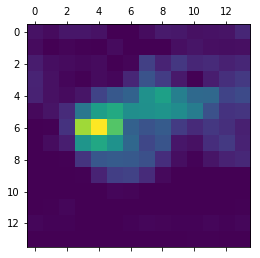

In [32]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
plt.matshow(heatmap)
plt.show()

In [33]:
import cv2

# cv2 모듈을 사용해 원본 이미지를 로드합니다
img = cv2.imread(img_path)

# heatmap을 원본 이미지 크기에 맞게 변경합니다
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

# heatmap을 RGB 포맷으로 변환합니다
heatmap = np.uint8(255 * heatmap)

# 히트맵으로 변환합니다
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

# 0.4는 히트맵의 강도입니다
superimposed_img = heatmap * 0.4 + img

# 디스크에 이미지를 저장합니다
cv2.imwrite('./datasets/elephant_cam.jpg', superimposed_img)

True